In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random

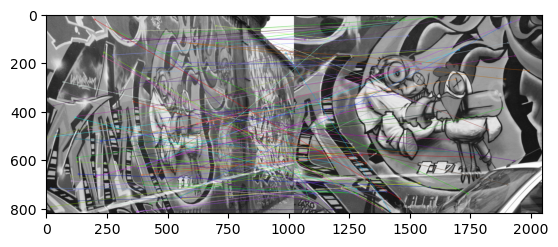

(<matplotlib.image.AxesImage at 0x1f55fd920d0>, None)

In [48]:
img1 = cv.imread('../../graf/img5.ppm')
img2 = cv.imread('../../graf/img1.ppm')

# Convert images to grayscale
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

def reSize(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv.resize(image,newSize)
    return image

img1 = reSize(img1)
img2 = reSize(img2)

#sift
sift = cv.SIFT_create()

kp1, descriptors_1 = sift.detectAndCompute(img1,None)
kp5, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv.drawMatches(img1, kp1, img2, kp5, matches[:100], img2, flags=2)
plt.imshow(img3),plt.show()


In [53]:
# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
dst_pts = np.float32([kp5[m.trainIdx].pt for m in matches]).reshape(-1, 2)

# Helper function to normalize points (centroid shift and scaling)
def normalize_points(points):
    centroid = np.mean(points, axis=0)
    shifted_points = points - centroid
    scale = np.sqrt(2) / np.mean(np.linalg.norm(shifted_points, axis=1))
    normalized_points = shifted_points * scale
    
    # Create transformation matrix to apply to the points
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])
    
    return normalized_points, T

# Function to compute homography using the DLT algorithm
def compute_homography(src_pts, dst_pts):
    # Normalize the points
    src_pts, T_src = normalize_points(src_pts)
    dst_pts, T_dst = normalize_points(dst_pts)
    
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        x_prime, y_prime = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, x_prime * x, x_prime * y, x_prime])
        A.append([0, 0, 0, -x, -y, -1, y_prime * x, y_prime * y, y_prime])
    
    A = np.array(A)
    
    # Perform SVD to solve for H (homography matrix)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    
    # Denormalize the homography matrix
    H = np.dot(np.linalg.inv(T_dst), np.dot(H, T_src))
    
    return H / H[-1, -1]  # Normalize so that H[2, 2] = 1

# Function to calculate the reprojection error
def reprojection_error(H, src_pts, dst_pts):
    src_pts_h = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
    dst_proj = np.dot(H, src_pts_h.T).T
    dst_proj = dst_proj[:, :2] / dst_proj[:, 2].reshape(-1, 1)
    
    # Return the Euclidean distance between the projected points and the actual points
    return np.linalg.norm(dst_pts - dst_proj, axis=1)

# RANSAC for Homography estimation
def ransac_homography(src_pts, dst_pts, num_iter=1000, threshold=5.0):
    best_H = None
    max_inliers = 0
    best_inliers = None
    
    for _ in range(num_iter):
        # Randomly sample 4 points
        sample_indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[sample_indices]
        dst_sample = dst_pts[sample_indices]
        
        # Compute homography using the DLT algorithm
        H = compute_homography(src_sample, dst_sample)
        
        # Compute reprojection error for all points
        errors = reprojection_error(H, src_pts, dst_pts)
        
        # Find inliers
        inliers = errors < threshold
        num_inliers = np.sum(inliers)
        
        # Update the best model if it has more inliers
        if num_inliers > max_inliers:
            best_H = H
            max_inliers = num_inliers
            best_inliers = inliers
    
    return best_H, best_inliers

# Example usage:
# Assuming `src_pts` and `dst_pts` are your matched point correspondences

# src_pts and dst_pts should be in shape (N, 2) where N is the number of correspondences
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])  # Source points (from the first image)
dst_pts = np.float32([kp5[m.trainIdx].pt for m in matches])  # Destination points (from the second image)

# Compute the homography using RANSAC
H, inliers = ransac_homography(src_pts, dst_pts)

print("Homography matrix computed using RANSAC:")
print(H)

Homography matrix computed using RANSAC:
[[-3.14938034e-01 -8.30198277e-01  6.10535678e+02]
 [-4.35408877e-01 -1.06561375e+00  8.01270226e+02]
 [-5.23942405e-04 -1.35355746e-03  1.00000000e+00]]
